In [1]:
from msedge.selenium_tools import Edge, EdgeOptions
from selenium.webdriver.common.keys import Keys
from time import sleep
import sys
import re
from collections import defaultdict
import pandas as pd
import datetime as dt
from datetime import timedelta
from hashlib import sha256
import os.path
from src import DATA_DIR
from hazm import Normalizer, sent_tokenize, word_tokenize
import plotly.express as px
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [16]:
class Twitter_scraper:
    def __init__(self, driver):
        self.driver = driver
        sleep(1)
        self.driver.get('https://twitter.com/explore')
        sleep(4)
        
    
    def save_file(self, list_, exprot_file_name):
        df = pd.DataFrame(list_, columns=['Tweet_ID', 'Username',
                                          'User_ID', 'DateTime',
                                          'Text', 'Reply_to',
                                          'Hashtag', 'Reply',
                                          'Retweet', 'Like',
                                         ])

        if not os.path.isfile(DATA_DIR / f'data/{exprot_file_name}.csv'):
            df.to_csv(DATA_DIR / f'data/{exprot_file_name}.csv', encoding="utf-8-sig", index=False)

        else:
            df.to_csv(DATA_DIR / f'data/{exprot_file_name}.csv', encoding="utf-8-sig", mode='a', header=False, index=False)
            
            
    
    def get_tweet_data(self, exprot_file_name, search_query:dict, max_tweet=None):
        
        ''' 
        *** Extract tweets ***
        
                :param search_query: (dict) Gets search query. The dictionary can have following keys:
                    - include: (list) Words that must be in tweet text. Each element is a list. This method will combine different elements with 'AND'
                      operator and each element words with 'OR' operator.

                    - not_include: (list) Words that shouldn't be in tweet text. Each element is a list. This method will combine different elements
                      with 'AND' operator and each element words with 'OR' operator.

                    - from: (list) Filters tweets that sent from specific Twitter accounts

                    - to: (list) Filters tweets that sent in reply to specific Twitter accounts

                    - since: (str, samp = “2015-12-21”) Containing tweets that sent since a specific date

                    - until: (str, samp = “2022-12-21”) Containing tweets that sent until a specific date

                    - mentioning: (list) Containing tweets that mentioning specific Twitter accounts

                    - question: ('True', 'False') If True, gets all tweet, that were recognized by twitter AI as a question

                :param max_tweet= (int) Ahen reachs to the number, running will stop

        '''
        
        # Read Unique IDs
        unique_tweet_ids = set()
        
        if os.path.isfile(DATA_DIR / f'data/{exprot_file_name}.csv'):
            df = pd.read_csv(DATA_DIR / f'data/{exprot_file_name}.csv', encoding="utf-8-sig")
            unique_tweet_ids = set(df.Tweet_ID)
        
        
        # Create Search Query
        serach_text = ''
        _ = []
        
        for elem in search_query['include']:
            _.append("((" + ") OR (".join(elem) + "))")
            
        serach_text = "((" + ") AND (".join(_) + "))"
        
        
        if 'not_include' in search_query.keys():
            _ = []
            for elem in search_query['not_include']:
                _.append("((" + ") AND (".join(elem) + "))")
                
            serach_text += " -((" + ") OR (".join(_) + "))"
        
        if 'from' in search_query.keys():
            serach_text += ' (from:' + ' OR from:'.join(search_query['from']) + ')'
            
        if 'to' in search_query.keys():
            serach_text += ' (to:' + ' OR to:'.join(search_query['to']) + ')'
            
        if 'lang' in search_query.keys():
            serach_text += ' lang:' + search_query['lang']
            
        if 'since' in search_query.keys():
            serach_text += f" since:{search_query['since']}"
            
        if 'until' in search_query.keys():
            serach_text += f" until:{search_query['until']}"
        
        if 'mentioning' in search_query.keys():
            serach_text += ' (@' + ' @'.join([search_query['mentioning']]) + ')'
        
        
        # Enter Search Query in Twitter search box
        sleep(3)
        search = self.driver.find_element('xpath', '//label[@data-testid="SearchBox_Search_Input_label"]')
        search.send_keys(Keys.CONTROL + "a")
        search.send_keys(Keys.DELETE)
        search.send_keys(serach_text)
        search.send_keys(Keys.RETURN)

        # Go to 'Latest' tweets
        sleep(10)
        self.driver.find_element('link text', 'Latest').click()

        # Scraping
        last_positon = self.driver.execute_script('return window.pageYOffset;')
        scrolling = True
        list_ = []
        progress = 1
        
        while scrolling:
            sleep(2)
            tweets = self.driver.find_elements('xpath', '//article[@data-testid="tweet"]')  

            for tweet in tweets[-min(24, len(tweets)-1):]:
                try:
                    reply_to, hashtag = str(), str()
                    text = tweet.find_element('xpath', './/div[@data-testid="tweetText"]').text

                    if 'Replying to \n@' in tweet.text:
                        reply_to = tweet.find_element(
                            'xpath', './/div[@class="css-901oao r-1bwzh9t r-37j5jr r-a023e6 r-16dba41 r-rjixqe r-bcqeeo r-qvutc0"]'
                        ).text.split()
                        reply_to = [id_ for id_ in reply_to if id_[0] == '@']

                    if '#' in text:
                        words = text.split()
                        hashtag = [word for word in words if word[0] == '#']

                    reply = tweet.find_element('xpath', './/div[@data-testid="reply"]').text
                    retweet = tweet.find_element('xpath', './/div[@data-testid="retweet"]').text
                    like = tweet.find_element('xpath', './/div[@data-testid="like"]').text

                    header = tweet.find_element('xpath', './/div[@data-testid="User-Names"]')
                    _ = header.find_element('xpath', './/time').get_attribute('datetime')
                    datetime = dt.datetime.strptime(_, '%Y-%m-%dT%H:%M:%S.000Z') + timedelta(hours=4.5)

                    info = header.text.split('@')
                    username = info[0].strip('\n')
                    user_id = '@' + info[1].split()[0]

                    tweet_id = sha256("".join([user_id, str(datetime), text]).encode()).hexdigest()
                    
                    
                    if tweet_id not in unique_tweet_ids:
                        sys.stdout.write('\r')
                        sys.stdout.write(f"Saved: {progress - progress % 100}     Current_State: [ Tweet: {progress}    Date: {str(datetime)[:7]} ] {' '*20}‌")
                        sys.stdout.flush()
                        progress += 1
                        
                        list_.append([tweet_id, username, user_id, datetime, text, reply_to, hashtag, reply, retweet, like])
                        unique_tweet_ids.add(tweet_id)
                        
                        if len(list_) >= 100 or progress > max_tweet:
                            self.save_file(list_, exprot_file_name)
                            list_ = []
                            
                        if progress > max_tweet:
                            scrolling = False
                            break
                            
                        if progress % 500 == 0:
                            search = self.driver.find_element('xpath', '//label[@data-testid="SearchBox_Search_Input_label"]')
                            search.send_keys(Keys.CONTROL + "a")
                            search.send_keys(Keys.DELETE)
                            search.send_keys(serach_text + str(datetime)[:10])
                            search.send_keys(Keys.RETURN)
                            sleep(10)
                        
                except:
                    pass
            
            # Scrolling
            scroll_attemp = 0
            
            while True:
                self.driver.execute_script('window.scrollTo(0, document.body.scrollHeight);')
                sleep(4)
                current_positon = self.driver.execute_script('return window.pageYOffset;')

                if current_positon == last_positon:
                    scroll_attemp += 1  
                    if scroll_attemp >= 4:
                        if len(list_) > 0:
                            self.save_file(list_, exprot_file_name)
                            list_ = []
                            
                        scrolling = False
                        break
                    else:
                        sleep(3)
                else:
                    last_positon = current_positon
                    break

### 
## Scraping Twitter

In [3]:
options = EdgeOptions()
options.use_chromium = True
options.add_argument("-inprivate")
options.binary_location = r"C:\Program Files (x86)\Microsoft\Edge\Application\msedge.exe"

driver = Edge('/mnt/f/msedgedriver.exe', options=options)

In [17]:
tweet = Twitter_scraper(driver)

##### 01_simple

In [18]:
tweet.get_tweet_data(
    search_query={'include': [['بورس', 'شاخص کل', 'فرابوس'
                              ],
                              ['شاخص کل', 'شاخص قیمت'
                              ],
                             ],
                  
                  'not_include': [['ایران',
                                  ],
                                  ['آخوند'
                                  ],
                                  ['جمهوری'
                                  ]
                                 ],
                  
                  'lang': 'fa',
                  
                 },
    max_tweet=None,
    exprot_file_name='All_In_One')

Saved: 0     Current_State: [ Tweet: 18    Date: 2022-08 ]                     ‌

KeyboardInterrupt: 

##### 02_complete version

In [ ]:
tweet.get_tweet_data(
                    search_query={'include': ['space', 'earth'],
                                  'include_operator': 'AND',
                                  'not_include': ['satellite'],
                                  'since': '2018-01-01',
                                  'until': '2022-01-01',
                                  'from': ['tonyandthesun'],
                                  'to': ['NASA', 'SpaceX'],
                                  'mentioning': ['SpaceX']
                                  
                    })

[] 1

### 
## Most Common Words

In [269]:
def remove_stopwords(text: str, stopwords: list):
    """
    :param text: text you want to delete stopwords from dat
    :param stopwords: list of stopwords
    """
    tokens = word_tokenize(text)
    tokens = filter(lambda word: word not in stopwords, tokens)
    return " ".join(tokens)

In [270]:
with open(DATA_DIR / 'Input/persian_stop_words.txt') as fp:
    stopwords = fp.read()

stopwords = stopwords.split()

In [271]:
df = pd.read_csv(DATA_DIR / 'data/All_In_One.csv')
df = df.loc[df.User_ID != '@DelliranC']
list_ = list(df.Text)
list_ = [set(str(text).split()) for text in list_]
list_ = [i for j in list_ for i in j]
text = ' '.join(list_)
text = text.replace('اچ پی', 'اچ_پی')
text = remove_stopwords(text, stopwords)
text = text.split(" ")

In [272]:
df = pd.DataFrame(Counter(text).most_common(), columns=['word', 'count'])
df.to_csv(DATA_DIR / 'data/most_common_words.csv', encoding="utf-8-sig", index=False)

In [273]:
df_ = pd.read_csv(DATA_DIR / 'Input/Themes.csv')

In [274]:
dict_ = defaultdict(int)
for i in range(len(df_)):
    try:
        dict_[df_.iloc[i, 0]] += int(df.loc[df.word==df_.iloc[i, 1], 'count'])
    except:
        pass
df__ = pd.DataFrame([[key, value] for key, value in dict_.items()], columns=['Brand', 'Count'])

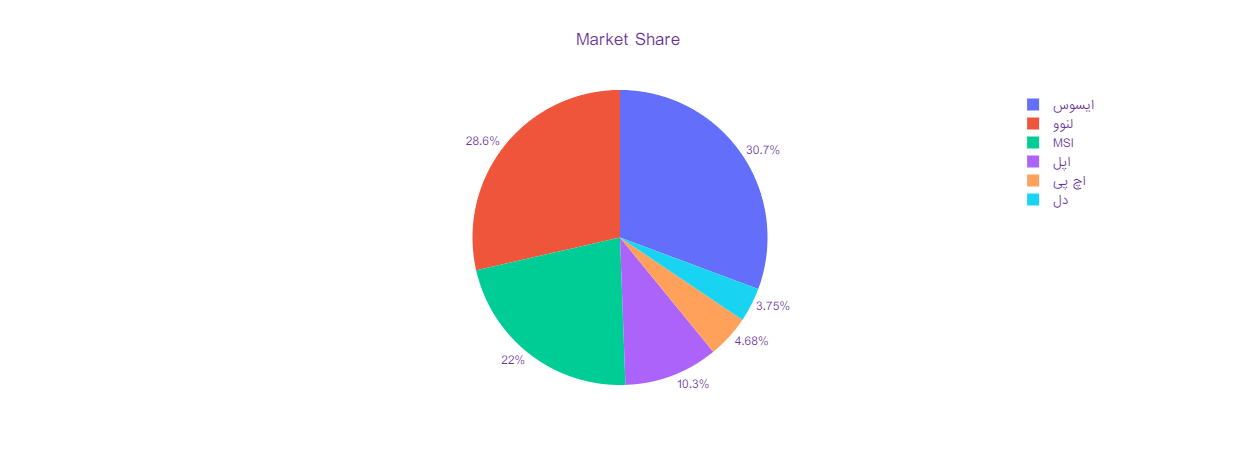

In [275]:
fig = px.pie(df__, values='Count', names='Brand')
fig.update_layout(autosize=False,
                  xaxis_title="",
                  yaxis_title="",
                  width=700, height=450,
                  margin=dict(l=65, r=50, b=65, t=90),
                  font=dict(
                      family="IRANSans",
                      size=12,
                      color="RebeccaPurple"
                  ))
fig.update_layout(title_text='Market Share', title_x=0.5)
fig.update_traces(textposition='outside')

fig.show()

In [278]:
df = pd.read_csv(DATA_DIR / 'data/All_In_One.csv')
df = df.loc[df.User_ID != '@DelliranC']

for text in df[df['Text'].str.contains("ایسوس")].Text:
    print(text)
    print('-'*100)

من از تاپ x541 ایسوس داشتم خراب شد تعمیر گاه گفت قطعه اش تحریم است و بعد از چند ماه برگرداند حالا کامپیوتر بدون کیس خریدم
----------------------------------------------------------------------------------------------------
فروش ویژه انواع کامپیوترهای همه کاره (آل این وان)

#فرازسیستم #فراز_سیستم
#کامپیوترهمه_کاره #آل_این_وان
#یونیوو #اچ_پی #گرین #ایسوس #لنوو #ام_اس_آی
#farazsystem #faraz_system 
#allinone #asus #univo #green #Lenovo #MSI #HP
----------------------------------------------------------------------------------------------------
مشخصات و ویژگی های کامپیوتر همه کاره 19.5 اینچی ایسوس مدل A4321 – A https://digitano.ir/%d9%85%d8%b4%d8%ae%d8%b5%d8%a7%d8%aa-%d9%88-%d9%88%db%8c%da%98%da%af%db%8c-%d9%87%d8%a7%db%8c-%da%a9%d8%a7%d9%85%d9%be%db%8c%d9%88%d8%aa%d8%b1-%d9%87%d9%85%d9%87-%da%a9%d8%a7-486/?utm_source=dlvr.it&utm_medium=twitter…
----------------------------------------------------------------------------------------------------
ال این وان میتونی msi بگیری ، خیلی خوبه ، ولی